# Описание проекта

Допустим, вы работаете в добывающей компании «ГлавРосГосНефть». Нужно решить, где бурить новую скважину.

Вам предоставлены пробы нефти в трёх регионах: в каждом 10 000 месторождений, где измерили качество нефти и объём её запасов. Постройте модель машинного обучения, которая поможет определить регион, где добыча принесёт наибольшую прибыль. Проанализируйте возможную прибыль и риски техникой *Bootstrap.*

Шаги для выбора локации:

- В избранном регионе ищут месторождения, для каждого определяют значения признаков;
- Строят модель и оценивают объём запасов;
- Выбирают месторождения с самым высокими оценками значений. Количество месторождений зависит от бюджета компании и стоимости разработки одной скважины;
- Прибыль равна суммарной прибыли отобранных месторождений.

План работы будет следующим:

1. [Исследуем предоствленные данные на пригодность их к обучению](#the_destination01)
2. [Создаём модель для каждого региона, определяем их эффективность, делаем предсказания, сохраняем результаты](#the_destination02)
3. [Определяем критерии безубыточности](#the_destination03)
4. [Техникой bootstrap вычисляем среднюю прибыль в регионах, определяем вероятность убытков и делаем вывод](#the_destination04)

<a id='the_destination01'></a>
# 1. Загрузка и подготовка данных 

Загружаем все необходимые библиотеки и файлы. id скважин нам здесь не неужны.

In [1]:
import pandas as pd
import numpy as np

from numpy.random import RandomState

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error

import matplotlib.pyplot as plt
import seaborn as sns

region0 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_0.csv', usecols=['f0', 'f1', 'f2', 'product'])
region1 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_1.csv', usecols=['f0', 'f1', 'f2', 'product'])
region2 = pd.read_csv('https://code.s3.yandex.net/datasets/geo_data_2.csv', usecols=['f0', 'f1', 'f2', 'product'])

state = RandomState(21)

Старая функция `column_info` показывает информацию по переменной.

In [2]:
def column_info(data, column, quantitative=False, mean=True, median=True, hist=True, bins=30):    
    lost = data[column].isna().sum() #смотрим количество пропусков
    total = data.shape[0] #длина всех значений переменной
    print('Тип данных столбца {}: {}:'.format(column, data[column].dtype))
    print('В столбце {} пропущено {} из {} строк, что составляет {:.2%}'
          .format(column, lost, total, lost / total)) #считаем процент пропусков
    if quantitative:        
        print('Минимальное значение: {}'.format(data[column].min()))
        print('Максимальное значение: {}'.format(data[column].max()))
        if mean:
            print('Среднее значение: {:.2f}'.format(data[column].mean()))
        if median:
            print('Медианное значение: {}'.format(data[column].median()))
        if hist:
            fig, axs = plt.subplots(ncols=2, figsize=(15, 5))
            sns.distplot(data[column], bins=bins, ax=axs[0])
            sns.boxplot(data[column], ax=axs[1])            
            plt.show()            
    else:
        print()
        print('Количество значений в каждой из категорий:')
        print(data[column].value_counts())        
    print()

Функция `trimmer` удаляет все выбросы. Есть предположение, что обучение без выбросов проходит лучше.

In [3]:
def trimmer(data, column):    
    _, bp = pd.DataFrame.boxplot(data[column], return_type='both')
    whiskers = [whiskers.get_ydata() for whiskers in bp["whiskers"]] 
    left_boundary = whiskers[0][1]
    right_boundary = whiskers[1][1]        
        
    data.loc[data[column] < left_boundary, column] = left_boundary
    data.loc[data[column] > right_boundary, column] = right_boundary
    plt.close('all')

Функция `bar_chart` выводит информацию с помощью баров в минималистичном виде.

In [4]:
def bar_chart(array, column_names, title, color='teal', figsize=(6,4)):
    plt.figure(figsize=figsize)    
    n = len(array)
    
    bars = plt.bar(np.arange(n), array, color=color)
    
    for bar in bars:
        height = bar.get_height()
        plt.gca().text(bar.get_x() + bar.get_width()/2, height*.90, '{0:.{1}f}'.format(height, 2), 
                     ha='center', color='w', fontsize=11)

    plt.tick_params(which='both', bottom=False, top=False, left=False, right=False, labelbottom=True) 
    
    for spine in plt.gca().spines.values():
        spine.set_visible(False)

    plt.xticks(range(n), column_names, alpha=0.8);
    plt.title(title, alpha=0.8)

Тип данных столбца f0: float64:
В столбце f0 пропущено 0 из 100000 строк, что составляет 0.00%
Минимальное значение: -1.4086053060269959
Максимальное значение: 2.3623308108542243
Среднее значение: 0.50
Медианное значение: 0.5023604550688835


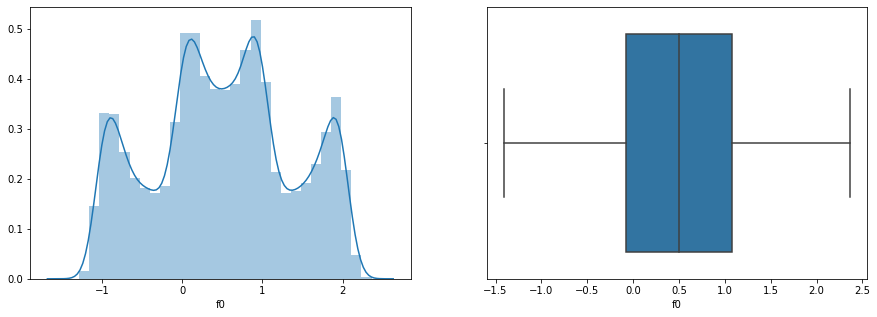


Тип данных столбца f1: float64:
В столбце f1 пропущено 0 из 100000 строк, что составляет 0.00%
Минимальное значение: -0.8482184970082173
Максимальное значение: 1.343769333804496
Среднее значение: 0.25
Медианное значение: 0.2502522879834579


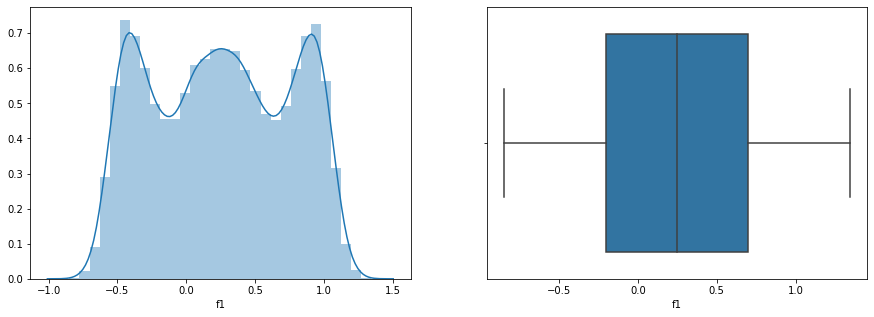


Тип данных столбца f2: float64:
В столбце f2 пропущено 0 из 100000 строк, что составляет 0.00%
Минимальное значение: -12.088328118063359
Максимальное значение: 16.003790007695365
Среднее значение: 2.50
Медианное значение: 2.5159691067559757


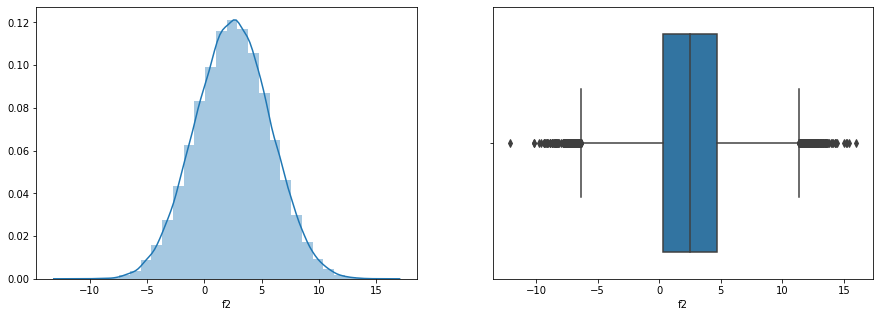


Тип данных столбца product: float64:
В столбце product пропущено 0 из 100000 строк, что составляет 0.00%
Минимальное значение: 0.0
Максимальное значение: 185.3643474222929
Среднее значение: 92.50
Медианное значение: 91.84997204396296


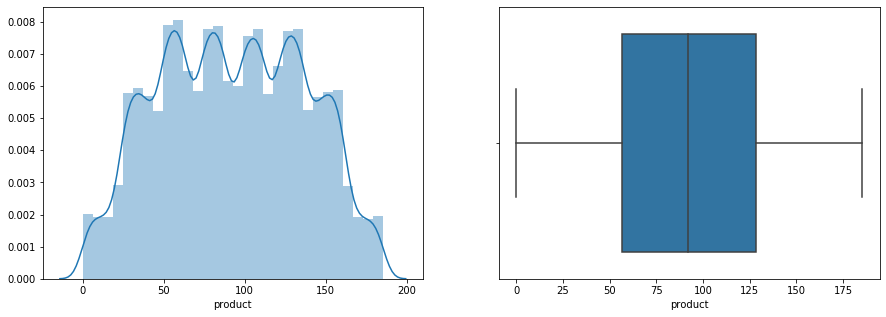


Матрица корреляции region0:


,f0,f1,f2,product
f0,1.000000,-0.440723,-0.003153,0.143536
f1,-0.440723,1.000000,0.001724,-0.192356
f2,-0.003153,0.001724,1.000000,0.483663
product,0.143536,-0.192356,0.483663,1.000000


In [5]:
column_info(region0, 'f0', quantitative=True)
column_info(region0, 'f1', quantitative=True)
column_info(region0, 'f2', quantitative=True)
column_info(region0, 'product', quantitative=True)

print('Матрица корреляции region0:')
region0.corr()

Есть выбросы. Целевая переменная примерно в 3 раза сильнее зависит от параметра f2, чем от остальных. А парметры f0 и f1 имеют среднюю корреляцию.

Тип данных столбца f0: float64:
В столбце f0 пропущено 0 из 100000 строк, что составляет 0.00%
Минимальное значение: -31.60957601916769
Максимальное значение: 29.42175461390372
Среднее значение: 1.14
Медианное значение: 1.1530552313242992


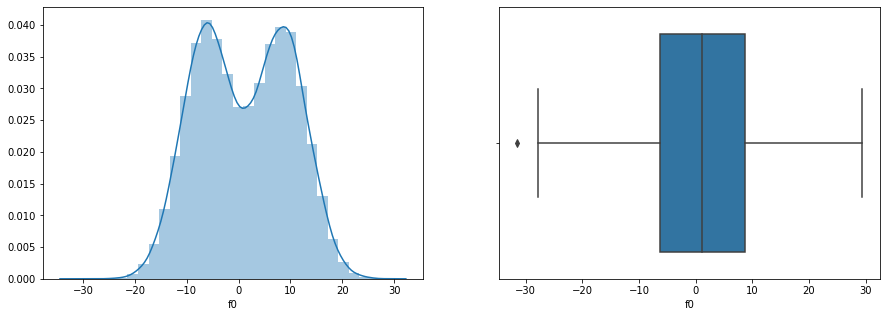


Тип данных столбца f1: float64:
В столбце f1 пропущено 0 из 100000 строк, что составляет 0.00%
Минимальное значение: -26.358598008345872
Максимальное значение: 18.734062633730762
Среднее значение: -4.80
Медианное значение: -4.813171838262699


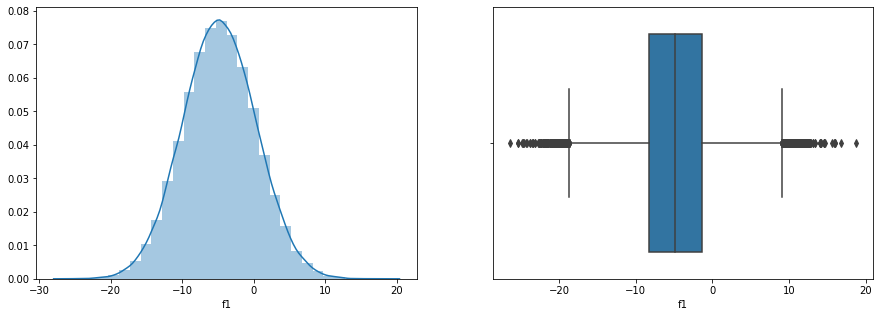


Тип данных столбца f2: float64:
В столбце f2 пропущено 0 из 100000 строк, что составляет 0.00%
Минимальное значение: -0.01814408671342021
Максимальное значение: 5.019720555223062
Среднее значение: 2.49
Медианное значение: 2.0114785491201994


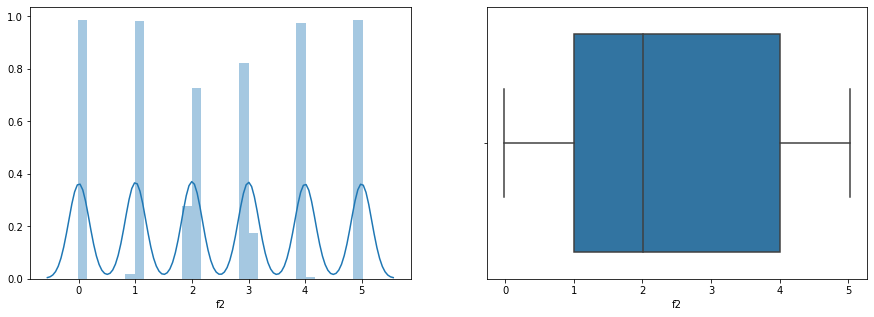


Тип данных столбца product: float64:
В столбце product пропущено 0 из 100000 строк, что составляет 0.00%
Минимальное значение: 0.0
Максимальное значение: 137.94540774090564
Среднее значение: 68.83
Медианное значение: 57.08562464628662


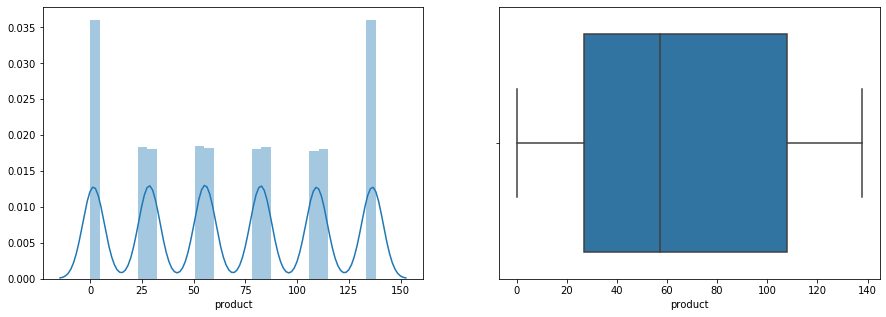


Матрица корреляции region1:


,f0,f1,f2,product
f0,1.000000,0.182287,-0.001777,-0.030491
f1,0.182287,1.000000,-0.002595,-0.010155
f2,-0.001777,-0.002595,1.000000,0.999397
product,-0.030491,-0.010155,0.999397,1.000000


In [6]:
column_info(region1, 'f0', quantitative=True)
column_info(region1, 'f1', quantitative=True)
column_info(region1, 'f2', quantitative=True)
column_info(region1, 'product', quantitative=True)

print('Матрица корреляции region1:')
region1.corr()

Есть выбросы. Почти прямая зависимость целевой переменной от параметра f2. Влияние других параметров пренебрежимо мало.

Тип данных столбца f0: float64:
В столбце f0 пропущено 0 из 100000 строк, что составляет 0.00%
Минимальное значение: -8.760003624213763
Максимальное значение: 7.23826247979405
Среднее значение: 0.00
Медианное значение: 0.00942358979364585


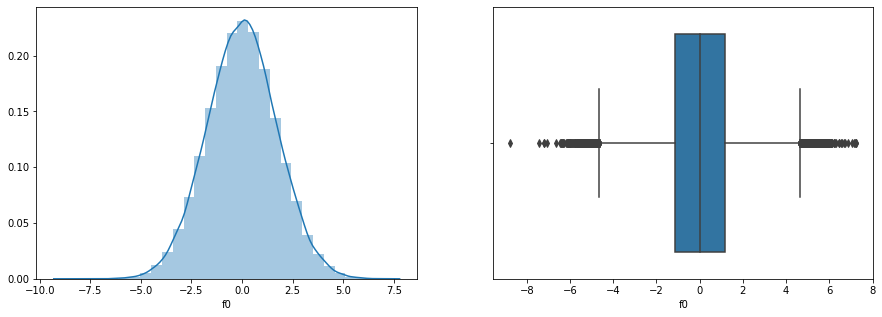


Тип данных столбца f1: float64:
В столбце f1 пропущено 0 из 100000 строк, что составляет 0.00%
Минимальное значение: -7.084019760867246
Максимальное значение: 7.844801270084258
Среднее значение: -0.00
Медианное значение: -0.009482163074430639


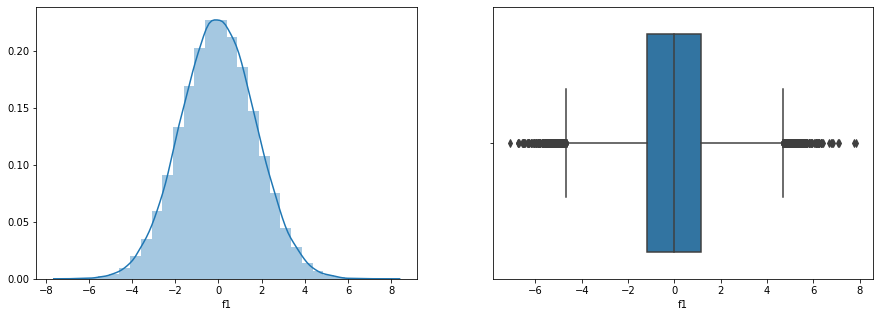


Тип данных столбца f2: float64:
В столбце f2 пропущено 0 из 100000 строк, что составляет 0.00%
Минимальное значение: -11.97033454147699
Максимальное значение: 16.73940205869952
Среднее значение: 2.50
Медианное значение: 2.4842358439369527


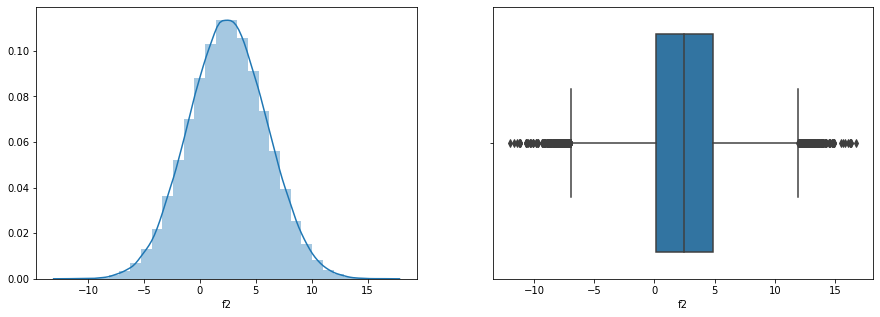


Тип данных столбца product: float64:
В столбце product пропущено 0 из 100000 строк, что составляет 0.00%
Минимальное значение: 0.0
Максимальное значение: 190.02983834335132
Среднее значение: 95.00
Медианное значение: 94.92561258990246


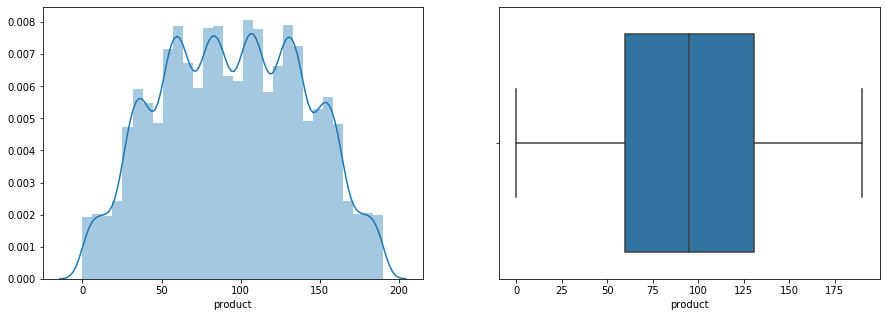


Матрица корреляции region2:


,f0,f1,f2,product
f0,1.000000,0.000528,-0.000448,-0.001987
f1,0.000528,1.000000,0.000779,-0.001012
f2,-0.000448,0.000779,1.000000,0.445871
product,-0.001987,-0.001012,0.445871,1.000000


In [7]:
column_info(region2, 'f0', quantitative=True)
column_info(region2, 'f1', quantitative=True)
column_info(region2, 'f2', quantitative=True)
column_info(region2, 'product', quantitative=True)

print('Матрица корреляции region2:')
region2.corr()

Есть выбросы. Целевая переменная средне зависит от параметра f2.

**Вывод** Наиболее важен во всех 3-х регионах параметр f2. Избавиться от выбросов мы сможем (на следующем шаге), а вот разобраться в переменных региона 2 не получится, так как их суть от нас скрыта, но что-то там не так.

In [8]:
for i in region0.columns:
    trimmer(region0, i)

for i in region1.columns:
    trimmer(region1, i)    

for i in region2.columns:
    trimmer(region2, i)

<a id='the_destination02'></a>
# 2. Обучение и проверка модели

Функция `data_split_scaler` сначала из выборки выделяет `features` и `target`, затем проводит масштабирование (это полезно для линейной регрессии), а на выходе даёт разделение на обучающую и валидационную выборки

In [9]:
def data_split_scaler(data, target):
    features = data.drop(target, axis=1)
    target = data[target]
    
    features_train, features_valid, target_train, target_valid = train_test_split(features, target, random_state=state)
    
    scaler = StandardScaler()
    scaler = scaler.fit(features_train)
    features_train = scaler.transform(features_train)
    features_valid = scaler.transform(features_valid)
    
    return features_train, features_valid, target_train, target_valid

Функция `predictions` обучает модель, а затем делает предсказание на валидационной выборке, также возвращает истинные ответы валидационной выборки и предсказания "средней" модели.

In [10]:
def predictions(data, target): 
    features_train, features_valid, target_train, target_valid = data_split_scaler(data, target)
    
    model = LinearRegression()
    model.fit(features_train, target_train)
    
    predictions_valid = model.predict(features_valid)
    
    mean_predictions = pd.Series(target_train.mean(), index=range(len(target_valid)))
    
    return target_valid, pd.Series(predictions_valid, index=target_valid.index), mean_predictions

Вычисляем метрику `rmse` для каждого региона для линейной регресии и "средней" модели..

In [11]:
region0_target_valid, region0_predictions_valid, region0_mean_predictions = predictions(region0, 'product')
region0_rmse = mean_squared_error(region0_target_valid, region0_predictions_valid) ** 0.5
region0_rmse_mean = mean_squared_error(region0_target_valid, region0_mean_predictions) ** 0.5

region1_target_valid, region1_predictions_valid, region1_mean_predictions = predictions(region1, 'product')
region1_rmse = mean_squared_error(region1_target_valid, region1_predictions_valid) ** 0.5
region1_rmse_mean = mean_squared_error(region1_target_valid, region1_mean_predictions) ** 0.5

region2_target_valid, region2_predictions_valid, region2_mean_predictions = predictions(region2, 'product')
region2_rmse = mean_squared_error(region2_target_valid, region2_predictions_valid) ** 0.5
region2_rmse_mean = mean_squared_error(region2_target_valid, region2_mean_predictions) ** 0.5

In [12]:
print('Среднее region0: {:.2f}'.format(region0_predictions_valid.mean()))
print('RMSE region0: {:.2f}'.format(region0_rmse))
print()
print('Среднее region1: {:.2f}'.format(region1_predictions_valid.mean()))
print('RMSE region1: {:.2f}'.format(region1_rmse))
print()
print('Среднее region2: {:.2f}'.format(region2_predictions_valid.mean()))
print('RMSE region2: {:.2f}'.format(region2_rmse))

Среднее region0: 92.60
RMSE region0: 37.87

Среднее region1: 69.04
RMSE region1: 0.89

Среднее region2: 94.82
RMSE region2: 40.01


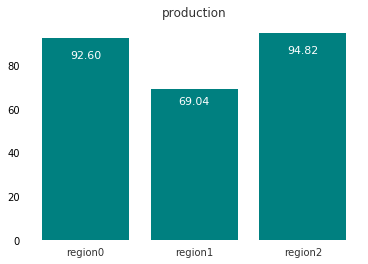

In [13]:
mean_production = [region0_predictions_valid.mean(), region1_predictions_valid.mean(), region2_predictions_valid.mean()]
column_names = ['region0', 'region1', 'region2']

bar_chart(mean_production, column_names, 'production')

В среднем добыча с одной скважены в region0 и region2 примерно одинаковая (в region2 чуть больше). В region1 добыча в среднем заметно меньше.

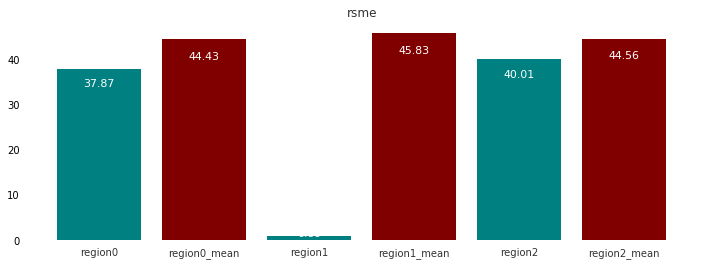

In [14]:
rsme = [region0_rmse, region0_rmse_mean, region1_rmse, region1_rmse_mean, region2_rmse, region2_rmse_mean]
column_names_rsme = ['region0', 'region0_mean', 'region1', 'region1_mean', 'region2', 'region2_mean']
color=['teal', 'maroon', 'teal', 'maroon', 'teal', 'maroon']

bar_chart(rsme, column_names_rsme, 'rsme', color=color, figsize=(12,4))

**Вывод** В region0 и region2 линейная модель даёт лучшее (согласно метрики rmse) предсказание, но нельзя сказать, что существенно лучше. А вот region1 опять особенный: линейная модель предсказывает добычу почти идеально. Возможно сказывается почти прямая корреляция с одним из параметров.

<a id='the_destination03'></a>
# 3. Подготовка к расчёту прибыли

In [15]:
N_WELLS = 500 #количество скважен в исследовании
BEST_WELLS = 200 #количество скважен, оторбранных для разработки
BUDGET = 10000000000 #бюджет всей кампании
EPS = 450000 #выручка с одной единицы продукции
LOSS_PROB = 0.025 #допустимая вероятность убытков

breakeven_well = BUDGET / (BEST_WELLS * EPS) #количество продукции, которое необходимо добывать со скважины для безубыточности
budget_well = BUDGET / BEST_WELLS # бюджет на одну скважину

In [16]:
print('Для безубыточности с одной скважины необходимо добывать {:.0f} тысяч барелей.'.format(breakeven_well))

Для безубыточности с одной скважины необходимо добывать 111 тысяч барелей.


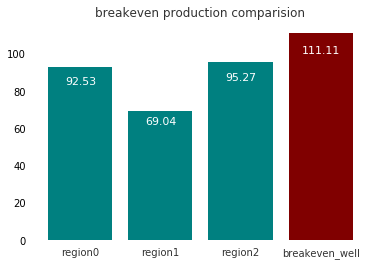

In [17]:
mean_production_target =[region0_target_valid.mean(), region1_target_valid.mean(), region2_target_valid.mean(), breakeven_well]
column_names.append('breakeven_well')

bar_chart(mean_production_target, column_names, 'breakeven production comparision', color=['teal', 'teal', 'teal', 'maroon'])

**Вывод** Если брать "среднюю" скважину в каждом регионе, то добыча будет убыточной. Поэтому нужно выбирать лучшие скважины по добыче.

<a id='the_destination04'></a>
# 4. Расчёт прибыли и рисков 

Функция `income` вычисляет прибыль с best_wells скважин, для этого она использует:
- predictons - список добычи со скважин
- eps - выручка с единицы продукции
- budget_well - затраты на разработку скважины

In [18]:
def income(target, predictons, budget_well):    
    best_wells_index = predictons.sort_values(ascending=False).index
    best_wells_target = target[best_wells_index][:BEST_WELLS]
    best_wells_revenue = [(i * EPS - budget_well) for i in best_wells_target]
    return  np.sum(best_wells_revenue)

In [19]:
income(region0_target_valid, region0_predictions_valid, budget_well)

3087035912.069786

In [20]:
MILLION = 1000000

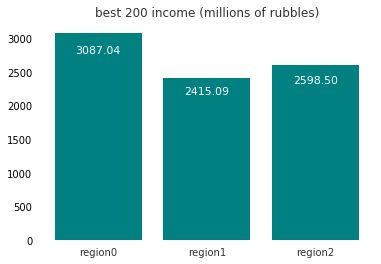

In [21]:
best_income = [income(region0_target_valid, region0_predictions_valid, budget_well) / MILLION, 
               income(region1_target_valid, region1_predictions_valid, budget_well) / MILLION,
               income(region2_target_valid, region2_predictions_valid, budget_well) / MILLION               
              ] 

bar_chart(best_income, column_names, 'best 200 income (millions of rubbles)')

**Вывод** Мы видим, что если использовать лучшие скважины из всех возможных, то добыча становится безубыточной. При этом 200-лучших скважин находятся в region0.

Функция income_distribution возвращает список, представляющий собой распределение прибыли на разных выборках из генеральной совокупности.

In [22]:
def income_distribution(target, predictions, number_itter, budget_well):    
    income_distribution_list = []      
    for i in range(number_itter):        
        subsample_target = target.sample(n=N_WELLS, replace=True, random_state=state)
        subsample_predictions = predictions[subsample_target.index]
        income_distribution_list.append(income(subsample_target, subsample_predictions, budget_well))
    return income_distribution_list 

Сохраняем распределения для каждого региона.

In [32]:
region0_income_distribution = income_distribution(region0_target_valid, region0_predictions_valid, 10000, budget_well)
region1_income_distribution = income_distribution(region1_target_valid, region1_predictions_valid, 1000, budget_well)
region2_income_distribution = income_distribution(region2_target_valid, region2_predictions_valid, 10000, budget_well)

Считаем среднюю прибыль по регионам.

In [33]:
region0_mean = np.mean(region0_income_distribution)
region1_mean = np.mean(region1_income_distribution)
region2_mean = np.mean(region2_income_distribution)

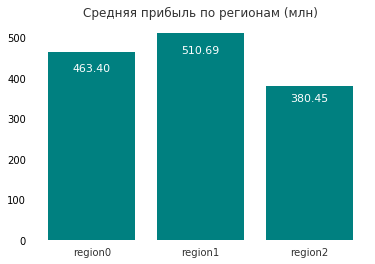

In [34]:
bar_chart([i / MILLION for i in [region0_mean, region1_mean, region2_mean]], column_names, 'Средняя прибыль по регионам (млн)')

Считаем доверительные интервалы для каждого из регионов.

In [35]:
region0_confidence_interval_low = np.percentile(region0_income_distribution, 2.5) / MILLION
region0_confidence_interval_up = np.percentile(region0_income_distribution, 97.5)  / MILLION

region1_confidence_interval_low = np.percentile(region1_income_distribution, 2.5)  / MILLION
region1_confidence_interval_up = np.percentile(region1_income_distribution, 97.5)  / MILLION

region2_confidence_interval_low = np.percentile(region2_income_distribution, 2.5)  / MILLION
region2_confidence_interval_up = np.percentile(region2_income_distribution, 97.5)  / MILLION

In [36]:
def confidence_interval_print(low, up, name):
    low_mln = round(low)
    up_mln = round(up)
    print('95% вероятность прибыли в {} от {} до {} (млн)'.format(name, low_mln, up_mln))

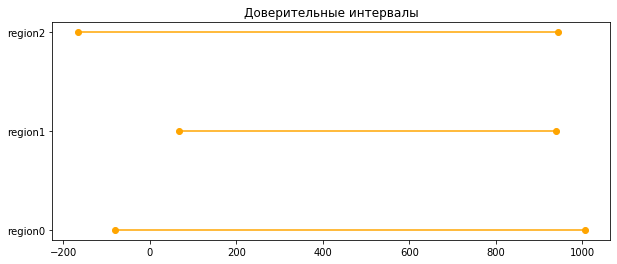

In [37]:
data_dict = {}
data_dict['category'] = ['region0','region1','region2']
data_dict['lower'] = [region0_confidence_interval_low, region1_confidence_interval_low, region2_confidence_interval_low]
data_dict['upper'] = [region0_confidence_interval_up, region1_confidence_interval_up, region2_confidence_interval_up]
dataset = pd.DataFrame(data_dict)

plt.figure(figsize=(10, 4))
for lower,upper,y in zip(dataset['lower'],dataset['upper'],range(len(dataset))):
    plt.plot((lower,upper),(y,y),'ro-',color='orange')

plt.yticks(range(len(dataset)),list(dataset['category']))
plt.title('Доверительные интервалы')
plt.show()

In [38]:
confidence_interval_print(region0_confidence_interval_low, region0_confidence_interval_up, 'region0')
confidence_interval_print(region1_confidence_interval_low, region1_confidence_interval_up, 'region1')
confidence_interval_print(region2_confidence_interval_low, region2_confidence_interval_up, 'region2')

95% вероятность прибыли в region0 от -81 до 1006 (млн)
95% вероятность прибыли в region1 от 67 до 940 (млн)
95% вероятность прибыли в region2 от -167 до 943 (млн)


Посчитаем вероятность отрицательной прибыли (убытка) по классическому определению вероятности, т.е. количество отрицательных значений поделим на количество всех значений.

In [39]:
region0_negative_income = [i for i in region0_income_distribution if i < 0]
region0_negative_income_probability = len(region0_negative_income) / len(region0_income_distribution)

region1_negative_income = [i for i in region1_income_distribution if i < 0]
region1_negative_income_probability = len(region1_negative_income) / len(region1_income_distribution)

region2_negative_income = [i for i in region2_income_distribution if i < 0]
region2_negative_income_probability = len(region2_negative_income) / len(region2_income_distribution)

In [40]:
print('Вероятность получить убыток в region0: {:.2%}'.format(region0_negative_income_probability))
print('Вероятность получить убыток в region1: {:.2%}'.format(region1_negative_income_probability))
print('Вероятность получить убыток в region2: {:.2%}'.format(region2_negative_income_probability))

Вероятность получить убыток в region0: 4.87%
Вероятность получить убыток в region1: 1.10%
Вероятность получить убыток в region2: 8.69%


**Вывод** Так как все 3 региона удовлетворили требованию по убытку (вероятность убытка не должна превышать 2.5%), то выбираем регион с наибольшей средней прибылью, а как было установленно ранее, это region1 c прибылью 466.1 млн. В region1 много очень хороших скважин и много плохих, так как при этом средний выход продукции по всей генеральной совокупности заметно меньше, чем в других регионах.